In [4]:
import tensorflow as tf
from tensorflow import keras
from attention_dynamic_model import AttentionDynamicModel
from utils import create_data_on_disk
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

2023-01-19 14:56:30.143863: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


# Solution Inspector Notebook

This notebook helps inspect the solutions produced by AM-D models.

In [5]:
# AM-D Initial Model Parameters. Make sure they match the original hyperparameters
embedding_dim   = 128
n_encode_layers = 3
n_heads         = 8
tanh_clipping   = 10

# Create model, duh!
model_amd = AttentionDynamicModel(
    embedding_dim  =embedding_dim,
    n_encode_layers=n_encode_layers,
    n_heads        =n_heads,
    tanh_clipping  =tanh_clipping
)

# Import weights.
model_amd.load_weights('TopologicalAttentionModel/_experiment_Jan-19-2023_14-45-58_nodes_10.ckp/AM-D_Jan-19-2023_14-45-58_nodes_10_epochs_50_batches_512.ckp')
#model_amd.load_weights('checkpoints/AM-D_example')

2023-01-19 14:56:33.987655: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-19 14:56:34.014025: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-19 14:56:34.014205: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-19 14:56:34.014629: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropri

In [6]:
# Generate data.
data = create_data_on_disk(10, 100, False, None, True, 42)

In [7]:
# This is only to see that data generated uses tf's dataset API
data

<TensorSliceDataset element_spec=(TensorSpec(shape=(2,), dtype=tf.float32, name=None), TensorSpec(shape=(10, 2), dtype=tf.float32, name=None), TensorSpec(shape=(10,), dtype=tf.float32, name=None))>

## Solve Problems

This section of the notebook shows the importation and use of an AM-D model to solve generated problems.

In [9]:
# Obtain data for testing
test_data = next(data.batch(5).as_numpy_iterator())

### Generate solutions using AM-D ###
model_amd.set_decode_type('greedy')
res = model_amd(test_data, return_pi=True)

In [10]:
res

(<tf.Tensor: shape=(5,), dtype=float32, numpy=
 array([4.979494 , 4.403771 , 4.4824023, 3.5372608, 3.6442447],
       dtype=float32)>,
 <tf.Tensor: shape=(5,), dtype=float32, numpy=
 array([-1.6185776 , -1.4369956 , -0.19168025, -1.1225768 , -0.5076527 ],
       dtype=float32)>,
 <tf.Tensor: shape=(5, 15), dtype=float32, numpy=
 array([[ 8.,  2.,  3.,  5.,  0.,  0.,  0.,  4., 10.,  7.,  9.,  0.,  6.,
          1.,  0.],
        [ 5.,  9.,  3.,  7.,  0.,  0.,  0.,  2.,  8.,  1.,  6.,  0.,  4.,
         10.,  0.],
        [ 5., 10.,  1.,  3.,  9.,  0.,  0.,  6.,  2.,  8.,  7.,  0.,  4.,
          0.,  0.],
        [ 1.,  9.,  6.,  7.,  3.,  0.,  0., 10.,  2.,  4.,  8.,  0.,  5.,
          0.,  0.],
        [ 1.,  5., 10.,  7.,  9.,  4.,  0.,  3.,  8.,  6.,  2.,  0.,  0.,
          0.,  0.]], dtype=float32)>)

In [11]:
# Which sample to vizualize?
testing_sample = 3

# Collect data for vizualization the original problem
start_node = pd.DataFrame([test_data[0][testing_sample]])
space_nodes = pd.DataFrame(test_data[1][testing_sample])
nodes = pd.concat([start_node, space_nodes]).reset_index(drop=True).rename(columns={0: 'x', 1: 'y'})

In [12]:
# Collect cost (reward is -cost)
cost = res[0][testing_sample]

# Note: res[1] is the log-likelihood used for REINFORCE, so we can ignore here.

# Collect chosen trajectories
selections = pd.DataFrame(res[2][testing_sample], columns=['node #']).astype(int)

In [13]:
selections

,node #
0,1
1,9
2,6
3,7
4,3
5,0
6,0
7,10
8,2
9,4


In [14]:
# Collect nodes' (x, y) locations
path = nodes.iloc[selections['node #']]
#path = path.rename(columns={0: 'x', 1: 'y'})

In [15]:
path

,x,y
1,0.633278,0.039127
9,0.710454,0.128864
6,0.743769,0.418242
7,0.695765,0.375767
3,0.558372,0.256420
0,0.186020,0.114308
0,0.186020,0.114308
10,0.050575,0.570597
2,0.075522,0.949766
4,0.015310,0.417871


In [16]:
# All of this code re-creates the above table but adds the labels for plotting initial problem

gen_data = test_data
sample   = testing_sample
__type   = 1 # 1: space nodes, 0: depot node
# Collect all other nodes
graph    = pd.DataFrame(gen_data[__type][sample], columns=['x', 'y'])
# Collect depot node
depot = {
    'x': gen_data[0][sample][0], 
    'y': gen_data[0][sample][1], 
    'type': 'depot'
}

graph = graph.assign(type='node').append(depot, ignore_index=True)

graph

/tmp/ipykernel_45681/53454811.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  graph = graph.assign(type='node').append(depot, ignore_index=True)


,x,y,type
0,0.633278,0.039127,node
1,0.075522,0.949766,node
2,0.558372,0.256420,node
3,0.015310,0.417871,node
4,0.322106,0.068197,node
5,0.743769,0.418242,node
6,0.695765,0.375767,node
7,0.079072,0.261432,node
8,0.710454,0.128864,node
9,0.050575,0.570597,node


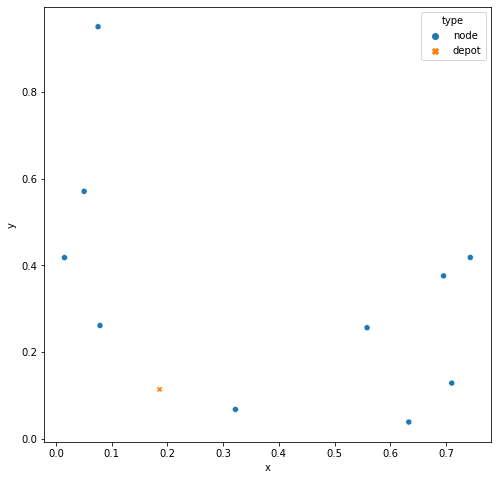

In [17]:
plt.figure(figsize=(8, 8))
sns.scatterplot(data=graph, x='x', y='y', hue='type', style='type')
plt.show()

/tmp/ipykernel_45681/670386366.py:14: RuntimeWarning: invalid value encountered in divide
  plt.quiver(pos_x, pos_y, u/norm, v/norm, angles="xy", zorder=0, pivot="tip", color='tab:blue')


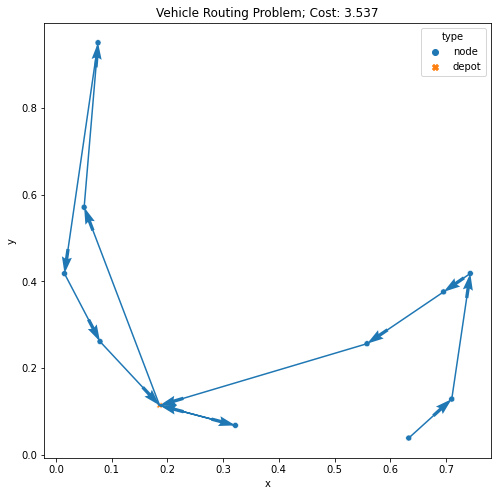

In [18]:
plt.figure(figsize=(8, 8))

x = path['x'].values
y = path['y'].values
u = np.diff(x)
v = np.diff(y)
pos_x = x[:-1] + u/1
pos_y = y[:-1] + v/1
norm = np.sqrt(u**2+v**2)

#plt.scatter(path[0], path[1], zorder=1)
sns.scatterplot(data=graph, x='x', y='y', hue='type', style='type')
plt.plot(path['x'], path['y'], zorder=2)
plt.quiver(pos_x, pos_y, u/norm, v/norm, angles="xy", zorder=0, pivot="tip", color='tab:blue')
plt.title(f'Vehicle Routing Problem; Cost: {cost:.3f}')
plt.show()